In [3]:
import pandas as pd
import numpy as np
import mne
import mne_bids
import matplotlib.pyplot as plt
import warnings
import scipy.signal

##### Generate coordsystem.json for each sub-ses folder

In [5]:
# import os
# import json

# root_path = 'data' # path to the dataset folder

# coordsystem_content = {
#     "EEGCoordinateSystem": "CapTrak",
#     "EEGCoordinateUnits": "mm",
#     "AnatomicalLandmarkCoordinates": {
#         "NAS": [0, 103, -11],
#         "LPA": [-83, 0, -11],
#         "RPA": [83, 0, -11]
#     },
#     "AnatomicalLandmarkCoordinateUnits": "mm"
# }

# def save_json(file_path, data):
#     with open(file_path, 'w') as fp:
#         json.dump(data, fp, indent=4)

# # generate one for each sub-ses folder
# for subdir, dirs, files in os.walk(root_path):
#     if subdir.endswith('eeg'):
#         parts = subdir.split(os.sep)
#         prefix = parts[-3] + '_' + parts[-2]
#         json_file_path = os.path.join(subdir, f"{prefix}_coordsystem.json")
#         save_json(json_file_path, coordsystem_content)
#         print(f'coordsystem.json created at {json_file_path}')


In [6]:
# load one set of eeg data
bids_path = mne_bids.BIDSPath(subject='14', session='1', task='eyesopen', datatype='eeg', root='data') # modify root to path to the data folder
raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()
print(raw.info)

Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_eeg.fdt
Reading channel info from data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-14/ses-1/eeg/sub-14_ses-1_electrodes.tsv.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF3, AF7, Fz, F1, F3, F5, F7, FC1, FC3, FC5, FT7, Cz, C1, ...
 chs: 61 EEG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 500.0 Hz
>


/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_90736/3833974829.py:3: RuntimeWarning: Did not find any events.tsv associated with sub-14_ses-1_task-eyesopen.

The search_str was "data/sub-14/**/eeg/sub-14_ses-1*events.tsv"
  raw = mne_bids.read_raw_bids(bids_path)
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_90736/3833974829.py:3: RuntimeWarning: participants.tsv file not found for data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_eeg.set
  raw = mne_bids.read_raw_bids(bids_path)


Using matplotlib as 2D backend.


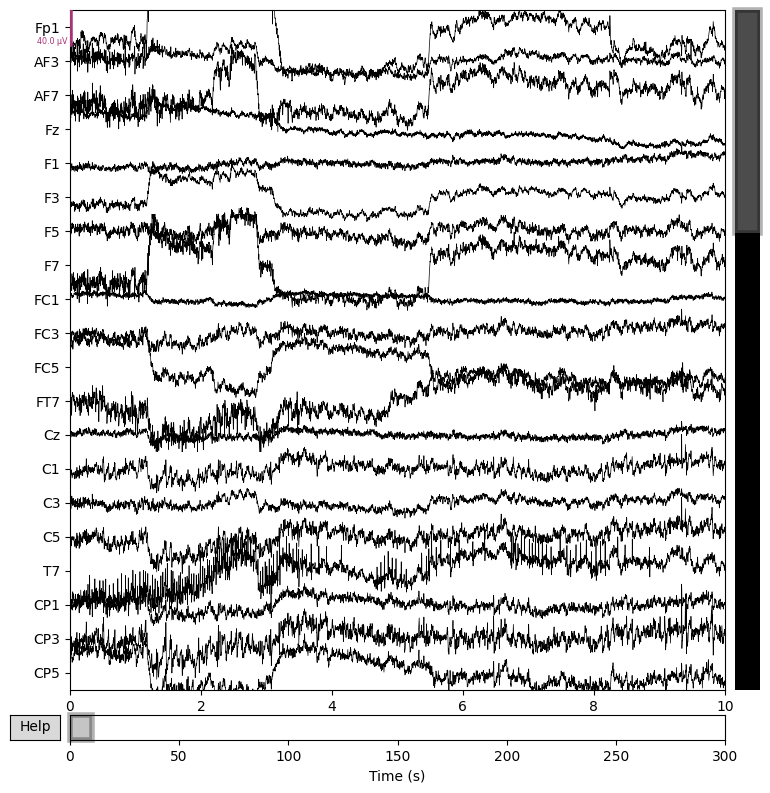

In [7]:
fig = raw.plot()

##### Extract relevant features from the raw EEG data

In [8]:
# extract power spectrum density (PSD)
data, times = raw[:, :]
sfreq = raw.info['sfreq']
f, Pxx = scipy.signal.welch(data[0], fs=sfreq, nperseg=1024, noverlap=512)

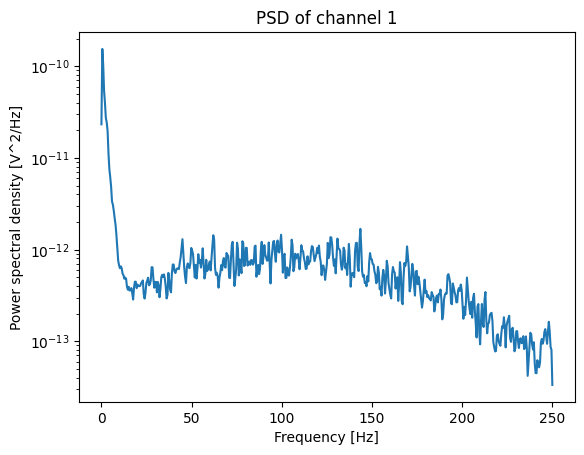

In [9]:
# one channel
plt.figure()
plt.semilogy(f, Pxx)
plt.title('PSD of channel 1')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density [V^2/Hz]')
plt.show()

In [10]:
print('Total of channels: ', len(raw.info['ch_names']))

Total of channels:  61


In [11]:
bands = {'delta': (1, 4),
         'theta': (4, 8),
         'alpha': (8, 12),
         'beta': (12, 30),
         'gamma': (30, 45)}

avg_band_powers = {band: np.zeros((data.shape[0],)) for band in bands}

for i in range(data.shape[0]):
    f, Pxx = scipy.signal.welch(data[i], fs=sfreq, nperseg=1024, noverlap=512)
    
    # Calculate average power in each band
    for band, (fmin, fmax) in bands.items():
        freq_mask = (f >= fmin) & (f <= fmax)
        avg_band_powers[band][i] = np.mean(Pxx[freq_mask])

for band, powers in avg_band_powers.items():
    print(f"Average {band} power per channel: {powers.shape}")

Average delta power per channel: (61,)
Average theta power per channel: (61,)
Average alpha power per channel: (61,)
Average beta power per channel: (61,)
Average gamma power per channel: (61,)


#### EDA on EEG data

In [12]:
df = pd.read_csv('cleaned_df.csv', index_col=0)
df.head()

,participant_id,Gender,Age,SessionOrder,PANAS_P_NS,PANAS_P_SD,PANAS_N_NS,PANAS_N_SD,SleepDiary_item1_NS,SleepDiary_item2_NS,SleepDiary_item3_NS,EQ,Buss_Perry,PSQI_GlobalScore,Sleep_time
13,sub-14,M,21,SD->NS,19,13.0,10,12.0,1:00,9:10,8.0,25.0,57.0,2.0,490
14,sub-15,M,19,SD->NS,22,11.0,14,17.0,2:00,8:00,8.0,31.0,71.0,6.0,360
15,sub-16,F,22,SD->NS,28,22.0,15,20.0,0:10,8:07,8.0,35.0,57.0,8.0,477
16,sub-17,F,18,SD->NS,36,21.0,20,23.0,0:14,8:03,7.0,40.0,58.0,6.0,469
17,sub-18,M,21,SD->NS,30,12.0,12,32.0,22:30,7:05,8.0,27.0,72.0,9.0,515


In [14]:
# def str_time_to_int(time_str):
#     hours, minutes = map(int, time_str.split(':'))
#     return hours + minutes / 60.0

# df['Sleep_time'] = df['Sleep_time'].apply(str_time_to_int)
# df.head()

In [15]:
df[df['SessionOrder'] == 'NS->SD'].shape

(30, 15)

##### Plot a few EEG examples of participants to compare between normal sleep and sleep deprivation conditions

Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_eeg.fdt
Reading channel info from data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-14/ses-1/eeg/sub-14_ses-1_electrodes.tsv.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-14/ses-2/eeg/sub-14_ses-2_task-eyesopen_eeg.fdt
Reading channel info from data/sub-14/ses-2/eeg/sub-14_ses-2_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-14/ses-2/eeg/sub-14_ses-2_electrodes.tsv.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-15/ses-1/eeg/sub-15_ses-1_task-eyesopen_eeg.fdt
Reading channel info from data/sub-15/ses-1/eeg/sub-15_ses-1_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-15/s

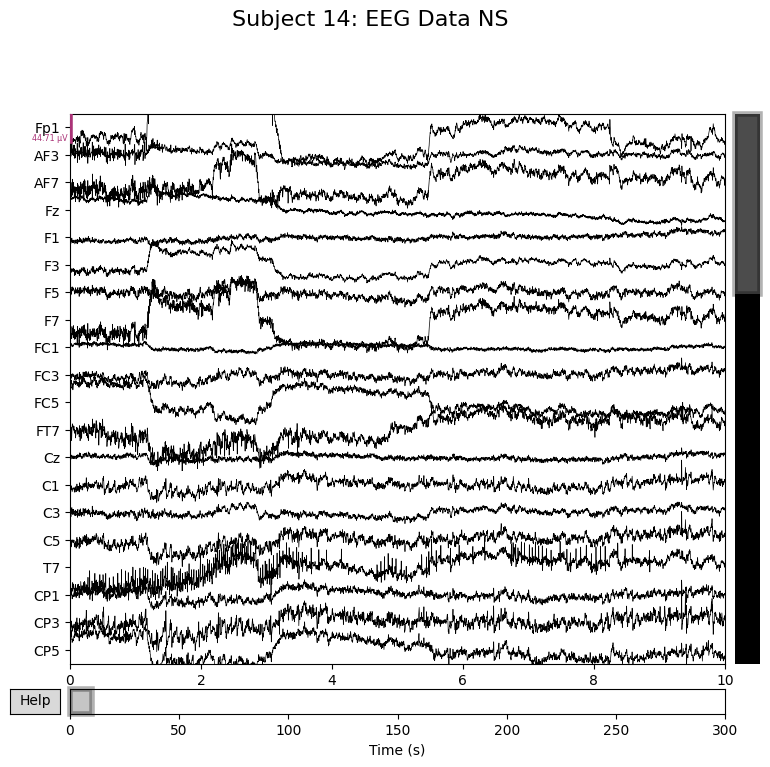

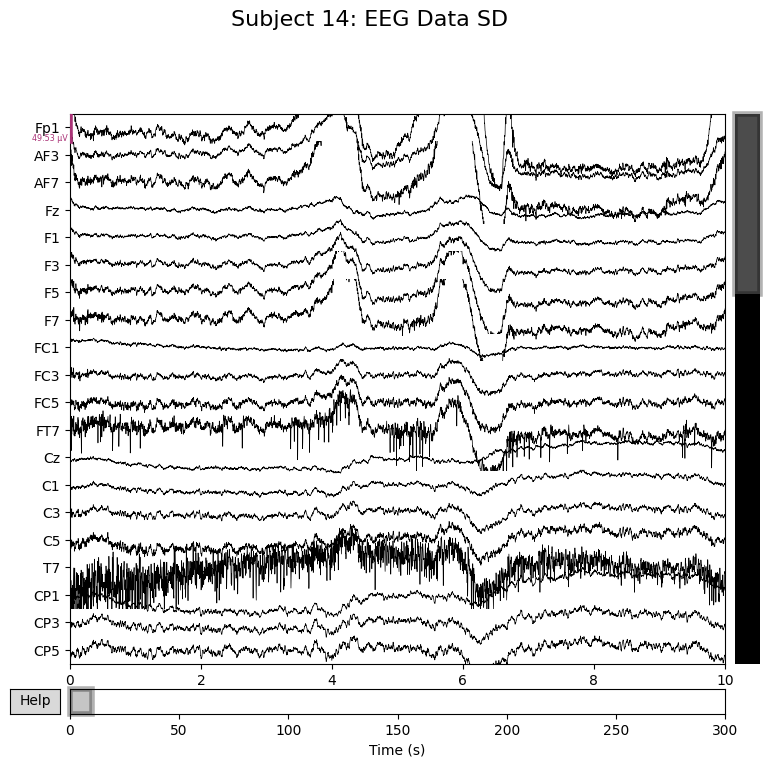

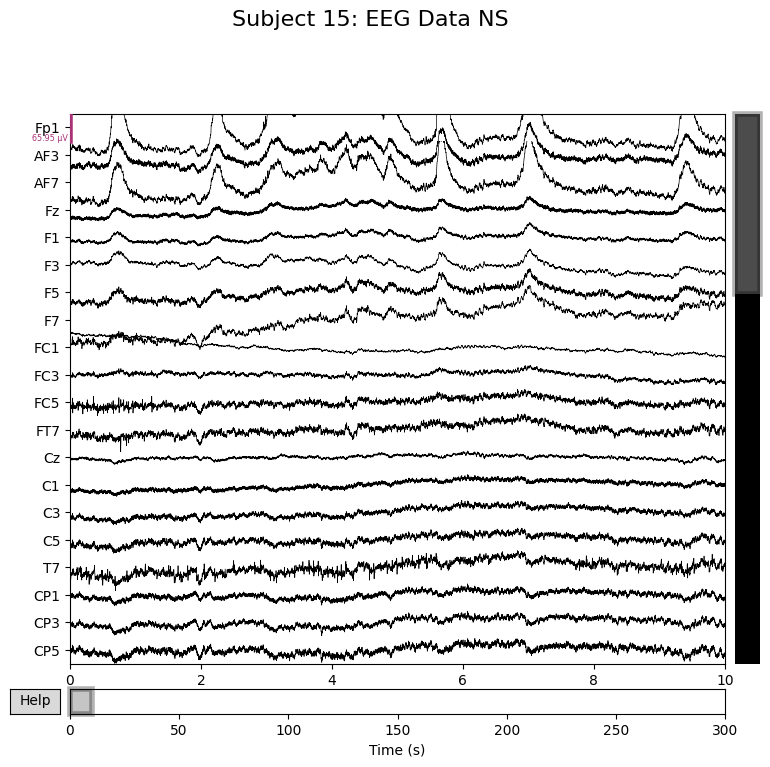

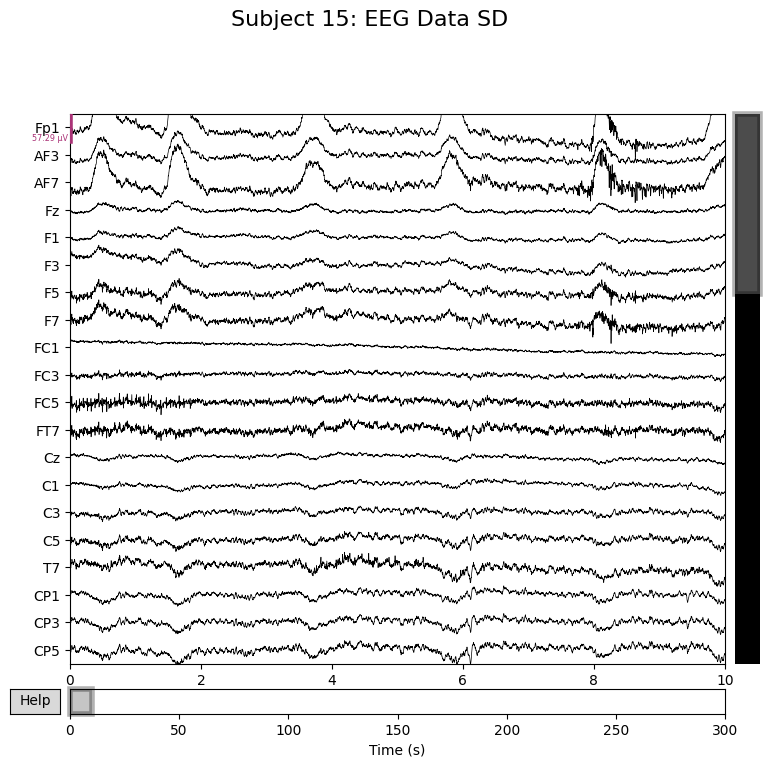

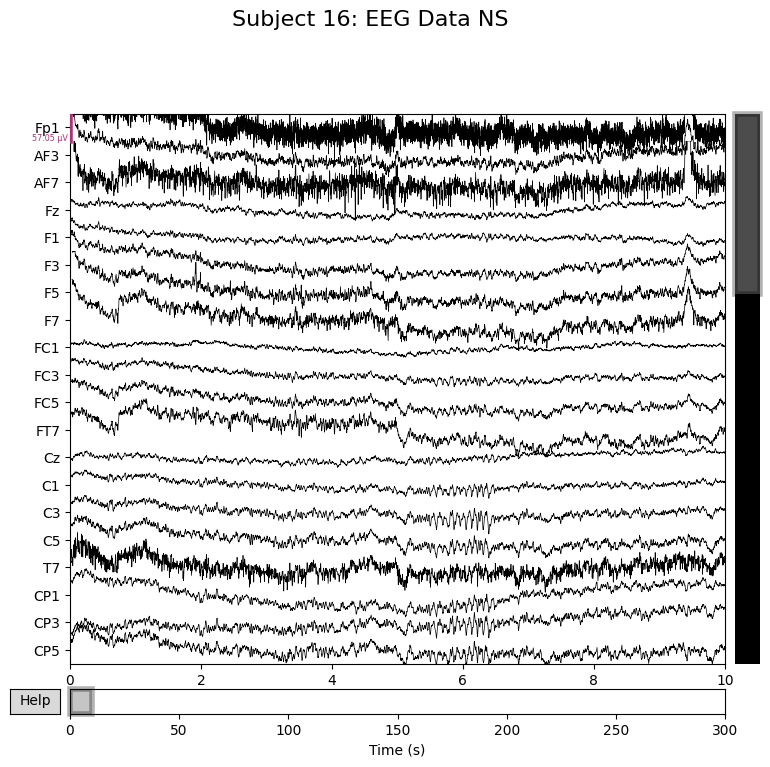

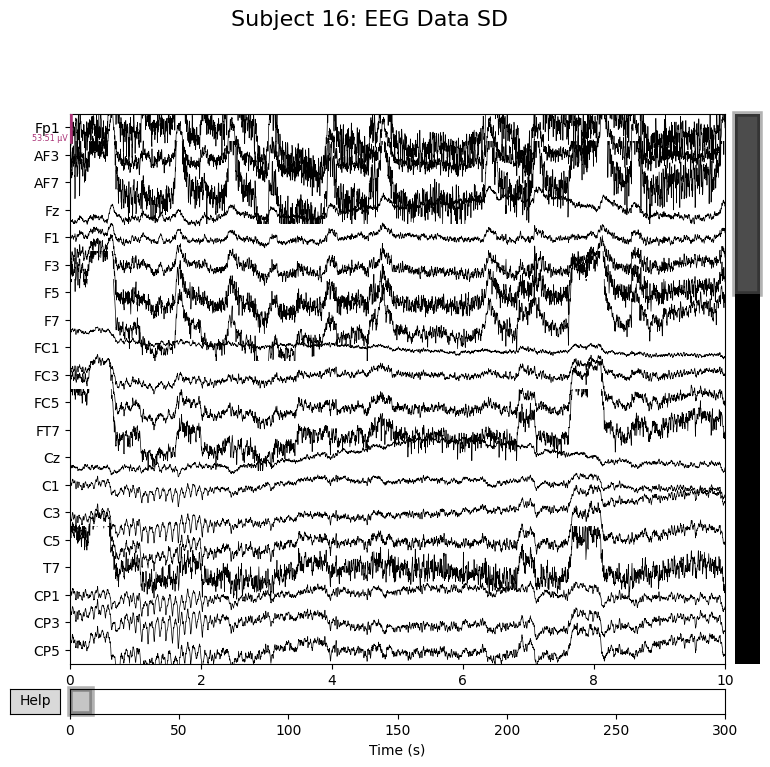

In [30]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Loop through the first 3 subjects
for i in df.index[:3]:
    if df.iloc[i].SessionOrder == 'SD->NS':
        ns_path = mne_bids.BIDSPath(subject=str(i+1), session='2', task='eyesopen', datatype='eeg', root='data')
        sd_path = mne_bids.BIDSPath(subject=str(i+1), session='1', task='eyesopen', datatype='eeg', root='data')
    else:
        ns_path = mne_bids.BIDSPath(subject=str(i+1), session='1', task='eyesopen', datatype='eeg', root='data')
        sd_path = mne_bids.BIDSPath(subject=str(i+1), session='2', task='eyesopen', datatype='eeg', root='data')

    raw = mne_bids.read_raw_bids(ns_path)
    raw.load_data()
    fig = raw.plot(scalings='auto', show=False, block=False)
    fig.suptitle(f'Subject {i+1}: EEG Data NS', fontsize=16)
    fig.subplots_adjust(top=0.85, bottom=0.1)

    raw = mne_bids.read_raw_bids(sd_path)
    raw.load_data()
    fig = raw.plot(scalings='auto', show=False, block=False)
    fig.suptitle(f'Subject {i+1}: EEG Data SD', fontsize=16)
    fig.subplots_adjust(top=0.85, bottom=0.1)

plt.show()


##### Restructure dataframe for model training

In [38]:
# features = ['Gender', 'Sleep_time', 'eeg']
# response = ['PSQI_GlobalScore']
# df['participant_id', 'Gender', 'NS/SD', 'Sleep_time', 'PSQI_GlobalScore']
feature_df = pd.DataFrame(columns=['participant_id', 'Condition', 'Gender', 'Age', 'SessionOrder', 'Sleep_time', 'PSQI_GlobalScore'])
new_rows = []
for i, row in df.iterrows():
    row1 = row[['participant_id', 'Gender', 'Age', 'SessionOrder', 'Sleep_time', 'PSQI_GlobalScore']]
    row2 = row[['participant_id', 'Gender', 'Age', 'SessionOrder', 'Sleep_time', 'PSQI_GlobalScore']]
    row1['Condition'] = 'NS'
    row2['Condition'] = 'SD'
    row2['Sleep_time'] = 0
    new_rows.append(row1)
    new_rows.append(row2)

feature_df = pd.concat(new_rows, axis=1).T.reset_index(drop=True)
feature_df

,participant_id,Gender,Age,SessionOrder,Sleep_time,PSQI_GlobalScore,Condition
0,sub-14,M,21,SD->NS,490,2.0,NS
1,sub-14,M,21,SD->NS,0,2.0,SD
2,sub-15,M,19,SD->NS,360,6.0,NS
3,sub-15,M,19,SD->NS,0,6.0,SD
4,sub-16,F,22,SD->NS,477,8.0,NS
...,...,...,...,...,...,...,...
95,sub-67,F,21,SD->NS,0,6.0,SD
96,sub-68,F,21,SD->NS,450,5.0,NS
97,sub-68,F,21,SD->NS,0,5.0,SD
98,sub-69,F,18,NS->SD,195,6.0,NS


In [39]:
# extract channel frequency data from eeg and append to df
warnings.filterwarnings("ignore", category=RuntimeWarning)

for band in bands.keys():
    feature_df[band] = None

bands = {'delta': (1, 4),
         'theta': (4, 8),
         'alpha': (8, 12),
         'beta': (12, 30),
         'gamma': (30, 45)}

for i, row in feature_df.iterrows():
    subject_id = row['participant_id'][-2:]
    if (subject_id == '28') or (subject_id == '44') :
        continue
    if (row['SessionOrder'] == 'SD->NS') & (row['Condition'] == 'SD'):
        bids_path = mne_bids.BIDSPath(subject=subject_id, session='1', task='eyesopen', datatype='eeg', root='data')
    elif (row['SessionOrder'] == 'NS->SD') & (row['Condition'] == 'NS'):
        bids_path = mne_bids.BIDSPath(subject=subject_id, session='1', task='eyesopen', datatype='eeg', root='data')
    else:
        bids_path = mne_bids.BIDSPath(subject=subject_id, session='2', task='eyesopen', datatype='eeg', root='data')
        
    raw = mne_bids.read_raw_bids(bids_path)
    raw.load_data()
    data, times = raw[:, :]
    sfreq = raw.info['sfreq']
    f, Pxx = scipy.signal.welch(data[0], fs=sfreq, nperseg=1024, noverlap=512)

    # calculate average power of each channel (61) for each frequency band (5)
    avg_band_powers = {band: np.zeros((data.shape[0],)) for band in bands}

    for channel in range(data.shape[0]):
        f, Pxx = scipy.signal.welch(data[channel], fs=sfreq, nperseg=1024, noverlap=512)
        
        for band, (fmin, fmax) in bands.items():
            freq_mask = (f >= fmin) & (f <= fmax)
            avg_band_powers[band][channel] = np.mean(Pxx[freq_mask])

    # append the freq info dict to feature_df
    # feature_df.at[i, 'eeg_band_powers'] = avg_band_powers
    for band in bands.keys():
        feature_df.at[i, band] = avg_band_powers[band]

feature_df.head()


Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-14/ses-2/eeg/sub-14_ses-2_task-eyesopen_eeg.fdt
Reading channel info from data/sub-14/ses-2/eeg/sub-14_ses-2_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-14/ses-2/eeg/sub-14_ses-2_electrodes.tsv.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_eeg.fdt
Reading channel info from data/sub-14/ses-1/eeg/sub-14_ses-1_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-14/ses-1/eeg/sub-14_ses-1_electrodes.tsv.
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading /Users/sallyyu/Desktop/sleepdeprivation_COGS138/sleepdeprivation_COGS138/data/sub-15/ses-2/eeg/sub-15_ses-2_task-eyesopen_eeg.fdt
Reading channel info from data/sub-15/ses-2/eeg/sub-15_ses-2_task-eyesopen_channels.tsv.
Reading electrode coords from data/sub-15/s

,participant_id,Gender,Age,SessionOrder,Sleep_time,PSQI_GlobalScore,Condition,delta,theta,alpha,beta,gamma
0,sub-14,M,21,SD->NS,490,2.0,NS,"[4.788007318280583e-11, 1.1410003899297911e-11...","[4.874742071880923e-12, 2.3427050790756055e-12...","[1.0038481892636442e-12, 5.287305748707404e-13...","[3.6796495468168673e-13, 1.8814597511115056e-1...","[1.7591243334886392e-13, 6.256921082073885e-14..."
1,sub-14,M,21,SD->NS,0,2.0,SD,"[2.939094800392051e-11, 2.186013810538341e-12,...","[3.965532431851802e-12, 5.74348193468407e-13, ...","[7.965038580454835e-13, 3.218741477196769e-13,...","[4.2358750601358724e-13, 6.975385241325517e-13...","[5.49324804451643e-13, 1.392169912734357e-12, ..."
2,sub-15,M,19,SD->NS,360,6.0,NS,"[3.6837187767970666e-11, 8.858380678204295e-12...","[3.1271114251718726e-12, 1.6872874607458691e-1...","[1.4724089023726969e-12, 8.724933891542623e-13...","[4.3145652710002126e-13, 2.0354489978791242e-1...","[2.1467906150779086e-13, 5.570002772095053e-14..."
3,sub-15,M,19,SD->NS,0,6.0,SD,"[3.6495914418734623e-11, 8.306926511138041e-12...","[2.2154920818854117e-12, 1.0720942411612999e-1...","[1.3863968987269667e-12, 8.277851648384084e-13...","[3.526809564414188e-13, 2.0455308726632353e-13...","[1.1887171537767715e-13, 6.385700955575279e-14..."
4,sub-16,F,22,SD->NS,477,8.0,NS,"[1.280667679558567e-10, 3.1050706350998434e-11...","[1.3647169797173806e-11, 4.2636458377437694e-1...","[2.56302498768805e-12, 1.123821195789776e-12, ...","[5.897398451039971e-12, 1.6010762984234377e-12...","[4.71569911571864e-12, 1.2760588556234085e-12,..."


In [41]:
print(feature_df['delta'].isnull().sum())
feature_df.dropna(subset=bands.keys(), inplace=True)
print(feature_df.shape)

4
(96, 12)


In [42]:
feature_df.to_csv('feature_df.csv')

#### Predictive Model

In [35]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

##### Data Preprocessing

In [36]:
feature_df[]

,participant_id,Gender,Age,SessionOrder,Sleep_time,PSQI_GlobalScore,Condition,eeg_band_powers
0,sub-14,M,21,SD->NS,490,2.0,NS,"{'delta': [4.788007318280583e-11, 1.1410003899..."
1,sub-14,M,21,SD->NS,0,2.0,SD,"{'delta': [2.939094800392051e-11, 2.1860138105..."
2,sub-15,M,19,SD->NS,360,6.0,NS,"{'delta': [3.6837187767970666e-11, 8.858380678..."
3,sub-15,M,19,SD->NS,0,6.0,SD,"{'delta': [3.6495914418734623e-11, 8.306926511..."
4,sub-16,F,22,SD->NS,477,8.0,NS,"{'delta': [1.280667679558567e-10, 3.1050706350..."
...,...,...,...,...,...,...,...,...
95,sub-67,F,21,SD->NS,0,6.0,SD,"{'delta': [3.486965588193902e-10, 6.3195542003..."
96,sub-68,F,21,SD->NS,450,5.0,NS,"{'delta': [5.008058538331524e-10, 4.6232363006..."
97,sub-68,F,21,SD->NS,0,5.0,SD,"{'delta': [2.5539964196961337e-10, 4.373969040..."
98,sub-69,F,18,NS->SD,195,6.0,NS,"{'delta': [1.0031590264861761e-10, 2.618576630..."
